In [1]:
import torch
import pandas as pd
import numpy as np
import joblib
import torch.nn as nn
import torch.nn.functional as F
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import precision_score,f1_score,ConfusionMatrixDisplay,confusion_matrix,accuracy_score,classification_report
from sklearn.svm import SVC
import torch.optim as optim
from sklearn.model_selection import GridSearchCV


def get_result(y_test,pred):
    print('Acc',accuracy_score(y_test,pred))
    print('f1',f1_score(y_test,pred))
    print('precision',precision_score(y_test,pred))

# SVM Testing on best saved model

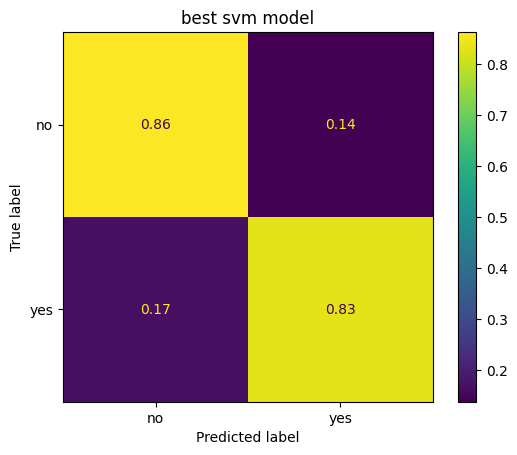

Acc 0.8587858011721774
f1 0.5873990306946688
precision 0.4535928143712575


In [2]:
best_svm_model = 'saved_model/SVM_upsampled_rbf.pkl'

test = pd.read_csv('dataset/test.csv',sep=',')
test.drop('poutcome',axis=1,inplace=True)
Xtest = test.drop('y',axis=1)
ytest = test['y']
ytest = ytest.replace(['yes','no'],[1,0])
# load preprocessor
loaded_preprocessor = joblib.load("saved_model/preprocessor.pkl")
Xtest = loaded_preprocessor.transform(Xtest)

# load model
clf = joblib.load(f"{best_svm_model}")

pred_svc = clf.predict(Xtest)
cm = confusion_matrix(ytest, pred_svc, labels=clf.classes_)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=['no','yes'])
disp.plot(values_format=".2f")
plt.title('best svm model')
plt.show()
get_result(ytest,pred_svc)

# MLP Testing on best saved model

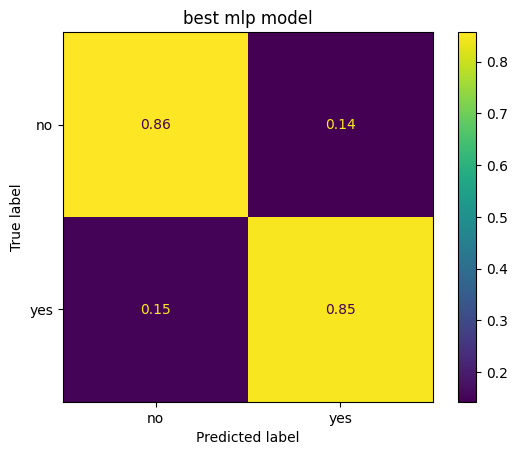

Acc 0.8561318146632755
f1 0.5878999049730758
precision 0.4491771539206196


In [3]:
# Define your PyTorch model
class StockClassifier(nn.Module):
    def __init__(self, input_dim,num_classes,dropout=0.5):
        super(StockClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_classes)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        X = self.dropout(x)
        x = self.fc3(x)
        return x

Mymodel = StockClassifier(47,2)

best_mlp_model = NeuralNetClassifier(module=Mymodel)
best_mlp_model.initialize()
best_mlp_model.load_params(f_params='saved_model/up_best_model_params.pkl',
                    f_optimizer='saved_model/up_best_optimizer_params.pkl', 
                    f_history='saved_model/up_best_history.json', 
                    f_pickle='saved_model/up_best_model.pkl')


test = pd.read_csv('dataset/test.csv',sep=',')
test.drop('poutcome',axis=1,inplace=True)
Xtest = test.drop('y',axis=1)
ytest = test['y']
ytest = ytest.replace(['yes','no'],[1,0])
# load preprocessor
loaded_preprocessor = joblib.load("saved_model/preprocessor.pkl")
Xtest = loaded_preprocessor.transform(Xtest)

X_test_tensor = torch.tensor(Xtest)
y_test_tensor = torch.tensor(ytest.values)
X_test_tensor = X_test_tensor.to(dtype=torch.float32)
y_test_tensor = y_test_tensor.to(torch.int64)

pred_mlp = best_mlp_model.predict(X_test_tensor)
cm = confusion_matrix(ytest, pred_mlp, labels=[0,1])
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=['no','yes'])
disp.plot(values_format=".2f")
plt.title('best mlp model')
plt.show()
get_result(y_test_tensor,pred_mlp)